In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

In [2]:
# load YOLO model:
model = YOLO('../models/best.pt')

In [3]:
# do the prediction with confidence level of maximum 0.2; iou allows for intersection of predicted boxes (lower values are stricter)
def predict(image_path):
    image = cv2.imread(image_path)

    # force model to use cpu even if trained on gpu
    results = model(image, conf=0.05, iou=0.25, device='cpu', classes=1) # 1=cars only for transfer learning model 
    return results[0]

In [4]:
# get image name wihtout extension from path
def extract_image_name(path):
    # Split the path by '/' and get the last part
    image_name = path.split('/')[-1]

    return image_name.replace('.jpg', '')

In [5]:
def test_plot_with_contour(image_path, prediction):
    contours, labels = prediction
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Convert color from BGR to RGB (OpenCV uses BGR by default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot each contour
    counter = 0
    for index, (contour, label) in enumerate(zip(contours, labels)):
        points = np.array(contour, dtype=np.int32)
        if label == 0:
            color = (0, 255, 0)
        else:
            color = (255, 0, 0)
        cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)

    # Display the image with contours
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
# make the xml code more readable
def prettify_xml(element, indent='  '):
    queue = [(0, element)]  # (level, element)
    while queue:
        level, element = queue.pop(0)
        children = list(element)
        if children:
            element.text = '\n' + indent * (level+1)  # for child open
        if queue:
            element.tail = '\n' + indent * queue[0][0]  # for sibling open
        else:
            element.tail = '\n' + indent * (level-1)  # for parent close
        queue[0:0] = [(level + 1, child) for child in children]

In [21]:
def export_prediction_xml(prediction, image_path, display_output=False, testing=False, write_xml=True):
    # Create the XML structure
    root = ET.Element("parking", id=image_path)
    contours = []
    labels = []
    id_counter = 1
    for box in prediction.boxes:
        # Create the <space> which equals to one parking spot
        label = int(box.cls.item())
        space = ET.SubElement(root, "space", id=str(id_counter), occupied=str(label), confidence=str(round(box.conf[0].item(), 4)))
        # Get the cords in xywh format
        cords = box.xywh[0].tolist()
        x, y, w, h = [round(x) for x in cords]
        # Get the cords in xyxy format
        cords = box.xyxy[0].tolist()
        x1, y1, x2, y2 = [round(x) for x in cords]
        # Rotated rectangle, that is not rotated - just keeping this for naming convention
        rotated_rect = ET.SubElement(space, "rotatedRect")
        ET.SubElement(rotated_rect, "center", x=str(x), y=str(y))
        ET.SubElement(rotated_rect, "size", w=str(w), h=str(h))
        # Contour
        contour = ET.SubElement(space, "contour")
        ET.SubElement(contour, "point", x=str(x1), y=str(y1))
        ET.SubElement(contour, "point", x=str(x2), y=str(y1))
        ET.SubElement(contour, "point", x=str(x2), y=str(y2))
        ET.SubElement(contour, "point", x=str(x1), y=str(y2))
        contours.append([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
        labels.append(label)
        id_counter += 1
    # Convert the XML structure to a string
    xml_string = ET.tostring(root, encoding='unicode')
    if display_output:
        print("XML content generated successfully.")
    if testing:
        return contours, labels, xml_string
    else:
        return xml_string

In [16]:
def show_images_with_boxes(image_path, original_xml):
    # Bild laden
    image = cv2.imread(image_path)

    # XML-String analysieren
    root = ET.fromstring(original_xml)

    # Kopiere das Originalbild für die Anzeige der Boxen
    image_with_boxes = image.copy()

    # Iteriere durch jede Box im XML
    for space in root.iter('space'):
        space_id = int(space.attrib['id'])

        # Extrahiere Koordinaten und Winkel aus XML (Konturkoordinaten)
        contour_points = []
        for point in space.iter('point'):
            x = int(point.attrib['x'])
            y = int(point.attrib['y'])
            contour_points.append((x, y))

        # Konvertiere die Konturpunkte in ein NumPy-Array
        contour_np = np.array(contour_points, dtype=np.int32)
        contour_np = contour_np.reshape((-1, 1, 2))

        # Zeichne ein Rechteck um die Konturpunkte auf dem Bild mit Boxen
        cv2.polylines(image_with_boxes, [contour_np], isClosed=True, color=(0, 255, 0), thickness=2)

        # Extrahiere Winkel aus XML
        try:
            angle = float(space.find('./rotatedRect/angle').attrib['d'])
        except (AttributeError, ValueError):
            # Falls angle nicht extrahiert werden kann oder ein ValueError auftritt, setze angle auf 0
            angle = 0.0

        # Extrahiere Zentrum aus XML
        center_x = float(space.find('./rotatedRect/center').attrib['x'])
        center_y = float(space.find('./rotatedRect/center').attrib['y'])
        center = (center_x, center_y)

        # Beschrifte das Bild mit der Box-ID
        cv2.putText(image_with_boxes, str(space_id), (int(center_x), int(center_y) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2, cv2.LINE_AA)

    # Anzeigen des Bildes mit den eingezeichneten Boxen im Output
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [12]:
def remove_spaces_by_ids(xml_original, ids_to_remove):
    # XML-String analysieren
    root = ET.fromstring(xml_original)

    # Iteriere über alle "space"-Elemente und entferne diejenigen mit den angegebenen IDs
    for space_id in ids_to_remove:
        space_to_remove = root.find(f'.//space[@id="{space_id}"]')
        if space_to_remove is not None:
            root.remove(space_to_remove)

    # Erstelle ein in-memory String-Buffer, um den aktualisierten XML-String zu speichern
    xml_buffer = io.StringIO()
    tree = ET.ElementTree(root)
    tree.write(xml_buffer)
    updated_xml = xml_buffer.getvalue()

    return updated_xml

In [17]:
def crop_images1(image_path, updated_xml_string):
    # Bild laden
    image = cv2.imread(image_path)

    # XML-String analysieren
    root = ET.fromstring(updated_xml_string)

    # Leeres Array für die ausgeschnittenen Boxen
    to_classify = []

    # Kopiere das Originalbild für die Anzeige der Boxen
    image_with_boxes = image.copy()

    # Iteriere durch jede Box im XML
    for space in root.iter('space'):
        space_id = int(space.attrib['id'])

        # Extrahiere Koordinaten und Winkel aus XML (Konturkoordinaten)
        contour_points = []
        for point in space.iter('point'):
            x = int(point.attrib['x'])
            y = int(point.attrib['y'])
            contour_points.append((x, y))

        # Konvertiere die Konturpunkte in ein NumPy-Array
        contour_np = np.array(contour_points, dtype=np.int32)
        contour_np = contour_np.reshape((-1, 1, 2))

        # Zeichne ein Rechteck um die Konturpunkte auf dem Bild mit Boxen
        cv2.polylines(image_with_boxes, [contour_np], isClosed=True, color=(0, 255, 0), thickness=2)
        
        # Extrahiere Winkel aus XML
        try:
            angle = float(space.find('./rotatedRect/angle').attrib['d'])
        except (AttributeError, ValueError):
            # Falls angle nicht extrahiert werden kann oder ein ValueError auftritt, setze angle auf 0
            angle = 0.0
        
        # Extrahiere Zentrum aus XML
        center_x = float(space.find('./rotatedRect/center').attrib['x'])
        center_y = float(space.find('./rotatedRect/center').attrib['y'])
        center = (center_x, center_y)

        # Berechne die Rotationsmatrix
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Rotiere das Bild
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

        # Schneide die Box aus dem rotierten Bild aus
        rect = cv2.boundingRect(contour_np)
        box_image = rotated_image[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]

        # Füge die ausgeschnittene Box zur Liste hinzu
        to_classify.append({'image': box_image, 'id': space_id, 'contour': contour_np})
        
        # Beschrifte das Bild mit der Box-ID
        cv2.putText(image_with_boxes, str(space_id), (rect[0], rect[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2, cv2.LINE_AA)

    # Anzeigen des Bildes mit den eingezeichneten Boxen im Output
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return to_classify, image_with_boxes

In [20]:
def ensemble_models(to_classify, model_paths):
    num_parking_spaces = len(to_classify)

    # Laden Sie die drei Modelle
    loaded_models = [load_model(model_path) for model_path in model_paths]

    data_transform = transforms.Compose([
        transforms.Resize((128, 128), interpolation=Image.BICUBIC),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    num_empty_spaces = 0
    num_occupied_spaces = 0
    empty_space_ids = []
    occupied_space_ids = []

    with torch.no_grad():
        for box_info in to_classify:
            image = box_info['image']

            # Transformiere das Bild
            image_transformed = data_transform(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
            image_tensor = torch.unsqueeze(image_transformed, 0)

            # Durchlaufe jedes Modell und speichere die Wahrscheinlichkeiten
            probabilities = []
            for loaded_model in loaded_models:
                outputs = loaded_model(image_tensor)
                probabilities.append(outputs.softmax(dim=1).numpy())

            # Berechne den Durchschnitt der Wahrscheinlichkeiten
            average_probabilities = np.mean(probabilities, axis=0)

            # Klassifiziere anhand des Durchschnitts
            prediction = np.argmax(average_probabilities)

            # Füge die Klassifizierung zum to_classify-Datensatz hinzu
            box_info['status'] = 'occupied' if prediction == 1 else 'empty'

            # Zählen Sie die Anzahl der leeren und besetzten Parkplätze im Batch
            if prediction == 0:
                num_empty_spaces += 1
                empty_space_ids.append(box_info['id'])
            else:
                num_occupied_spaces += 1
                occupied_space_ids.append(box_info['id'])

    print(f'Number of parking spaces: {num_parking_spaces}\nNumber of empty spaces: {num_empty_spaces}\nNumber of occupied spaces: {num_occupied_spaces}')
    print(f'Empty space IDs: {empty_space_ids}\nOccupied space IDs: {occupied_space_ids}')

    return num_parking_spaces, num_empty_spaces, num_occupied_spaces, empty_space_ids, occupied_space_ids



In [22]:
def visualize_results(image_path, updated_xml, model_path):
    # Visualize results with marked IDs
    image = image_with_boxes.copy()

    # Annahme: Du hast die Variablen occupied_space_ids und empty_space_ids bereits definiert
    for box_info in to_classify:
        space_id = box_info['id']
        contour_np = box_info['contour']

        if space_id in occupied_space_ids:
            cv2.polylines(image, [contour_np], isClosed=True, color=(0, 0, 255), thickness=2)
        elif space_id in empty_space_ids:
            cv2.polylines(image, [contour_np], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

0: 384x640 57 cars, 166.9ms
Speed: 28.2ms preprocess, 166.9ms inference, 18.6ms postprocess per image at shape (1, 3, 384, 640)


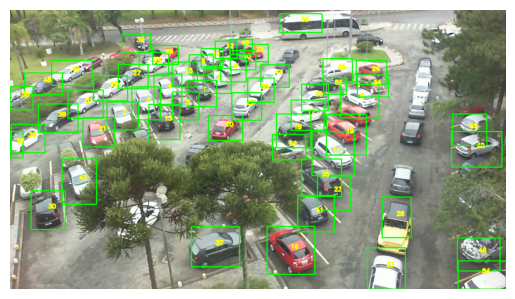

In [23]:
image_path = '../data/final/model_try/2012-12-17_10_50_06.jpg'

prediction = predict(image_path)
original_xml = export_prediction_xml(prediction, image_path)

show_images_with_boxes(image_path, original_xml)

In [24]:
ids_to_remove = [50,48,39,55,54,28]
updated_xml = remove_spaces_by_ids(original_xml, ids_to_remove)

OSError: [Errno 63] File name too long: '<parking id="../data/final/model_try/2012-12-17_10_50_06.jpg"><space id="1" occupied="1" confidence="0.5995"><rotatedRect><center x="495" y="215" /><size w="75" h="68" /></rotatedRect><contour><point x="458" y="181" /><point x="533" y="181" /><point x="533" y="249" /><point x="458" y="249" /></contour></space><space id="2" occupied="1" confidence="0.5942"><rotatedRect><center x="534" y="183" /><size w="70" h="65" /></rotatedRect><contour><point x="499" y="150" /><point x="570" y="150" /><point x="570" y="215" /><point x="499" y="215" /></contour></space><space id="3" occupied="1" confidence="0.5732"><rotatedRect><center x="351" y="241" /><size w="73" h="85" /></rotatedRect><contour><point x="314" y="198" /><point x="388" y="198" /><point x="388" y="283" /><point x="314" y="283" /></contour></space><space id="4" occupied="1" confidence="0.5605"><rotatedRect><center x="407" y="205" /><size w="72" h="81" /></rotatedRect><contour><point x="371" y="165" /><point x="443" y="165" /><point x="443" y="246" /><point x="371" y="246" /></contour></space><space id="5" occupied="1" confidence="0.5065"><rotatedRect><center x="453" y="247" /><size w="69" h="72" /></rotatedRect><contour><point x="419" y="211" /><point x="487" y="211" /><point x="487" y="283" /><point x="419" y="283" /></contour></space><space id="6" occupied="1" confidence="0.4884"><rotatedRect><center x="493" y="141" /><size w="62" h="52" /></rotatedRect><contour><point x="462" y="115" /><point x="524" y="115" /><point x="524" y="167" /><point x="462" y="167" /></contour></space><space id="7" occupied="1" confidence="0.4839"><rotatedRect><center x="290" y="273" /><size w="81" h="72" /></rotatedRect><contour><point x="250" y="237" /><point x="331" y="237" /><point x="331" y="309" /><point x="250" y="309" /></contour></space><space id="8" occupied="1" confidence="0.4701"><rotatedRect><center x="903" y="231" /><size w="99" h="95" /></rotatedRect><contour><point x="853" y="184" /><point x="952" y="184" /><point x="952" y="278" /><point x="853" y="278" /></contour></space><space id="9" occupied="1" confidence="0.4284"><rotatedRect><center x="576" y="154" /><size w="66" h="61" /></rotatedRect><contour><point x="543" y="124" /><point x="609" y="124" /><point x="609" y="185" /><point x="543" y="185" /></contour></space><space id="10" occupied="1" confidence="0.4004"><rotatedRect><center x="601" y="129" /><size w="67" h="50" /></rotatedRect><contour><point x="568" y="104" /><point x="634" y="104" /><point x="634" y="154" /><point x="568" y="154" /></contour></space><space id="11" occupied="1" confidence="0.3966"><rotatedRect><center x="833" y="370" /><size w="109" h="111" /></rotatedRect><contour><point x="779" y="314" /><point x="888" y="314" /><point x="888" y="426" /><point x="779" y="426" /></contour></space><space id="12" occupied="1" confidence="0.3881"><rotatedRect><center x="557" y="102" /><size w="56" h="45" /></rotatedRect><contour><point x="529" y="80" /><point x="585" y="80" /><point x="585" y="125" /><point x="529" y="125" /></contour></space><space id="13" occupied="1" confidence="0.3801"><rotatedRect><center x="398" y="289" /><size w="80" h="91" /></rotatedRect><contour><point x="358" y="243" /><point x="438" y="243" /><point x="438" y="334" /><point x="358" y="334" /></contour></space><space id="14" occupied="1" confidence="0.3443"><rotatedRect><center x="521" y="122" /><size w="56" h="47" /></rotatedRect><contour><point x="493" y="99" /><point x="549" y="99" /><point x="549" y="146" /><point x="493" y="146" /></contour></space><space id="15" occupied="1" confidence="0.3417"><rotatedRect><center x="451" y="166" /><size w="65" h="64" /></rotatedRect><contour><point x="418" y="134" /><point x="483" y="134" /><point x="483" y="198" /><point x="418" y="198" /></contour></space><space id="16" occupied="1" confidence="0.3362"><rotatedRect><center x="724" y="620" /><size w="124" h="124" /></rotatedRect><contour><point x="663" y="558" /><point x="786" y="558" /><point x="786" y="682" /><point x="663" y="682" /></contour></space><space id="17" occupied="1" confidence="0.329"><rotatedRect><center x="767" y="271" /><size w="85" h="78" /></rotatedRect><contour><point x="725" y="232" /><point x="810" y="232" /><point x="810" y="310" /><point x="725" y="310" /></contour></space><space id="18" occupied="1" confidence="0.3272"><rotatedRect><center x="732" y="311" /><size w="89" h="86" /></rotatedRect><contour><point x="687" y="268" /><point x="776" y="268" /><point x="776" y="355" /><point x="687" y="355" /></contour></space><space id="19" occupied="1" confidence="0.3108"><rotatedRect><center x="867" y="322" /><size w="103" h="105" /></rotatedRect><contour><point x="816" y="269" /><point x="919" y="269" /><point x="919" y="374" /><point x="816" y="374" /></contour></space><space id="20" occupied="1" confidence="0.3074"><rotatedRect><center x="556" y="304" /><size w="88" h="64" /></rotatedRect><contour><point x="512" y="272" /><point x="600" y="272" /><point x="600" y="336" /><point x="512" y="336" /></contour></space><space id="21" occupied="1" confidence="0.3057"><rotatedRect><center x="229" y="315" /><size w="82" h="76" /></rotatedRect><contour><point x="188" y="277" /><point x="270" y="277" /><point x="270" y="353" /><point x="188" y="353" /></contour></space><space id="22" occupied="1" confidence="0.304"><rotatedRect><center x="610" y="248" /><size w="76" h="71" /></rotatedRect><contour><point x="572" y="213" /><point x="649" y="213" /><point x="649" y="284" /><point x="572" y="284" /></contour></space><space id="23" occupied="1" confidence="0.3013"><rotatedRect><center x="836" y="472" /><size w="86" h="87" /></rotatedRect><contour><point x="793" y="428" /><point x="879" y="428" /><point x="879" y="516" /><point x="793" y="516" /></contour></space><space id="24" occupied="1" confidence="0.3005"><rotatedRect><center x="933" y="161" /><size w="79" h="62" /></rotatedRect><contour><point x="893" y="130" /><point x="972" y="130" /><point x="972" y="192" /><point x="893" y="192" /></contour></space><space id="25" occupied="1" confidence="0.2985"><rotatedRect><center x="787" y="226" /><size w="69" h="69" /></rotatedRect><contour><point x="752" y="191" /><point x="821" y="191" /><point x="821" y="260" /><point x="752" y="260" /></contour></space><space id="26" occupied="1" confidence="0.2817"><rotatedRect><center x="371" y="139" /><size w="76" h="60" /></rotatedRect><contour><point x="333" y="109" /><point x="409" y="109" /><point x="409" y="169" /><point x="333" y="169" /></contour></space><space id="27" occupied="1" confidence="0.2633"><rotatedRect><center x="317" y="172" /><size w="77" h="63" /></rotatedRect><contour><point x="279" y="140" /><point x="356" y="140" /><point x="356" y="203" /><point x="279" y="203" /></contour></space><space id="28" occupied="1" confidence="0.2632"><rotatedRect><center x="997" y="535" /><size w="75" h="105" /></rotatedRect><contour><point x="960" y="482" /><point x="1035" y="482" /><point x="1035" y="587" /><point x="960" y="587" /></contour></space><space id="29" occupied="1" confidence="0.2622"><rotatedRect><center x="259" y="201" /><size w="89" h="65" /></rotatedRect><contour><point x="215" y="169" /><point x="303" y="169" /><point x="303" y="234" /><point x="215" y="234" /></contour></space><space id="30" occupied="1" confidence="0.2293"><rotatedRect><center x="98" y="516" /><size w="88" h="100" /></rotatedRect><contour><point x="54" y="466" /><point x="142" y="466" /><point x="142" y="566" /><point x="54" y="566" /></contour></space><space id="31" occupied="1" confidence="0.2145"><rotatedRect><center x="194" y="243" /><size w="92" h="73" /></rotatedRect><contour><point x="149" y="206" /><point x="240" y="206" /><point x="240" y="279" /><point x="149" y="279" /></contour></space><space id="32" occupied="1" confidence="0.2057"><rotatedRect><center x="634" y="111" /><size w="63" h="45" /></rotatedRect><contour><point x="603" y="88" /><point x="666" y="88" /><point x="666" y="133" /><point x="603" y="133" /></contour></space><space id="33" occupied="1" confidence="0.1944"><rotatedRect><center x="971" y="666" /><size w="98" h="107" /></rotatedRect><contour><point x="922" y="613" /><point x="1020" y="613" /><point x="1020" y="720" /><point x="922" y="720" /></contour></space><space id="34" occupied="1" confidence="0.1936"><rotatedRect><center x="937" y="196" /><size w="81" h="57" /></rotatedRect><contour><point x="896" y="167" /><point x="977" y="167" /><point x="977" y="224" /><point x="896" y="224" /></contour></space><space id="35" occupied="1" confidence="0.1924"><rotatedRect><center x="804" y="433" /><size w="103" h="97" /></rotatedRect><contour><point x="752" y="384" /><point x="855" y="384" /><point x="855" y="481" /><point x="752" y="481" /></contour></space><space id="36" occupied="1" confidence="0.1884"><rotatedRect><center x="47" y="331" /><size w="88" h="73" /></rotatedRect><contour><point x="3" y="295" /><point x="90" y="295" /><point x="90" y="368" /><point x="3" y="368" /></contour></space><space id="37" occupied="1" confidence="0.187"><rotatedRect><center x="530" y="610" /><size w="124" h="103" /></rotatedRect><contour><point x="468" y="559" /><point x="592" y="559" /><point x="592" y="662" /><point x="468" y="662" /></contour></space><space id="38" occupied="1" confidence="0.1851"><rotatedRect><center x="124" y="279" /><size w="102" h="74" /></rotatedRect><contour><point x="73" y="242" /><point x="175" y="242" /><point x="175" y="316" /><point x="73" y="316" /></contour></space><space id="39" occupied="1" confidence="0.1829"><rotatedRect><center x="326" y="86" /><size w="74" h="47" /></rotatedRect><contour><point x="288" y="62" /><point x="363" y="62" /><point x="363" y="110" /><point x="288" y="110" /></contour></space><space id="40" occupied="1" confidence="0.1703"><rotatedRect><center x="596" y="94" /><size w="58" h="38" /></rotatedRect><contour><point x="567" y="75" /><point x="625" y="75" /><point x="625" y="114" /><point x="567" y="114" /></contour></space><space id="41" occupied="1" confidence="0.1591"><rotatedRect><center x="789" y="525" /><size w="96" h="93" /></rotatedRect><contour><point x="742" y="478" /><point x="837" y="478" /><point x="837" y="572" /><point x="742" y="572" /></contour></space><space id="42" occupied="1" confidence="0.1545"><rotatedRect><center x="1204" y="359" /><size w="130" h="92" /></rotatedRect><contour><point x="1139" y="313" /><point x="1269" y="313" /><point x="1269" y="405" /><point x="1139" y="405" /></contour></space><space id="43" occupied="1" confidence="0.1506"><rotatedRect><center x="178" y="442" /><size w="88" h="117" /></rotatedRect><contour><point x="134" y="384" /><point x="223" y="384" /><point x="223" y="501" /><point x="134" y="501" /></contour></space><space id="44" occupied="1" confidence="0.148"><rotatedRect><center x="159" y="162" /><size w="104" h="64" /></rotatedRect><contour><point x="107" y="130" /><point x="211" y="130" /><point x="211" y="194" /><point x="107" y="194" /></contour></space><space id="45" occupied="1" confidence="0.1323"><rotatedRect><center x="845" y="157" /><size w="76" h="64" /></rotatedRect><contour><point x="807" y="125" /><point x="883" y="125" /><point x="883" y="189" /><point x="807" y="189" /></contour></space><space id="46" occupied="1" confidence="0.1275"><rotatedRect><center x="1209" y="630" /><size w="110" h="86" /></rotatedRect><contour><point x="1154" y="588" /><point x="1264" y="588" /><point x="1264" y="673" /><point x="1154" y="673" /></contour></space><space id="47" occupied="1" confidence="0.1127"><rotatedRect><center x="683" y="170" /><size w="73" h="58" /></rotatedRect><contour><point x="647" y="141" /><point x="720" y="141" /><point x="720" y="199" /><point x="647" y="199" /></contour></space><space id="48" occupied="1" confidence="0.1083"><rotatedRect><center x="86" y="190" /><size w="98" h="56" /></rotatedRect><contour><point x="37" y="162" /><point x="135" y="162" /><point x="135" y="218" /><point x="37" y="218" /></contour></space><space id="49" occupied="1" confidence="0.0992"><rotatedRect><center x="401" y="116" /><size w="65" h="48" /></rotatedRect><contour><point x="368" y="91" /><point x="434" y="91" /><point x="434" y="140" /><point x="368" y="140" /></contour></space><space id="50" occupied="1" confidence="0.093"><rotatedRect><center x="30" y="227" /><size w="59" h="60" /></rotatedRect><contour><point x="0" y="197" /><point x="59" y="197" /><point x="59" y="257" /><point x="0" y="257" /></contour></space><space id="51" occupied="1" confidence="0.081"><rotatedRect><center x="838" y="196" /><size w="59" h="43" /></rotatedRect><contour><point x="809" y="174" /><point x="868" y="174" /><point x="868" y="217" /><point x="809" y="217" /></contour></space><space id="52" occupied="1" confidence="0.078"><rotatedRect><center x="720" y="354" /><size w="86" h="64" /></rotatedRect><contour><point x="677" y="321" /><point x="763" y="321" /><point x="763" y="386" /><point x="677" y="386" /></contour></space><space id="53" occupied="1" confidence="0.0764"><rotatedRect><center x="647" y="207" /><size w="68" h="63" /></rotatedRect><contour><point x="613" y="175" /><point x="681" y="175" /><point x="681" y="238" /><point x="613" y="238" /></contour></space><space id="54" occupied="1" confidence="0.0626"><rotatedRect><center x="1218" y="683" /><size w="124" h="73" /></rotatedRect><contour><point x="1156" y="647" /><point x="1280" y="647" /><point x="1280" y="720" /><point x="1156" y="720" /></contour></space><space id="55" occupied="1" confidence="0.0598"><rotatedRect><center x="1186" y="309" /><size w="89" h="81" /></rotatedRect><contour><point x="1142" y="268" /><point x="1230" y="268" /><point x="1230" y="349" /><point x="1142" y="349" /></contour></space><space id="56" occupied="1" confidence="0.0576"><rotatedRect><center x="751" y="34" /><size w="108" h="49" /></rotatedRect><contour><point x="696" y="9" /><point x="805" y="9" /><point x="805" y="58" /><point x="696" y="58" /></contour></space><space id="57" occupied="1" confidence="0.0553"><rotatedRect><center x="17" y="347" /><size w="33" h="68" /></rotatedRect><contour><point x="0" y="313" /><point x="33" y="313" /><point x="33" y="381" /><point x="0" y="381" /></contour></space></parking>'

In [ ]:
to_classify, image_with_boxes = crop_images1(image_path, updated_xml)
_, _, _, empty_space_ids, occupied_space_ids = ensemble_models(to_classify, model_paths)
visualize_results(image_path, xml_path, model_path)